In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import PIL
import time
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from IPython.display import display
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SubsetRandomSampler # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os, shutil
from tqdm.notebook import tqdm
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/camvid/CamVid/class_dict.csv
/kaggle/input/camvid/CamVid/test_labels/0001TP_009150_L.png
/kaggle/input/camvid/CamVid/test_labels/0001TP_007710_L.png
/kaggle/input/camvid/CamVid/test_labels/0006R0_f01350_L.png
/kaggle/input/camvid/CamVid/test_labels/0001TP_008070_L.png
/kaggle/input/camvid/CamVid/test_labels/0016E5_05730_L.png
/kaggle/input/camvid/CamVid/test_labels/0001TP_008460_L.png
/kaggle/input/camvid/CamVid/test_labels/0001TP_008250_L.png
/kaggle/input/camvid/CamVid/test_labels/0016E5_06570_L.png
/kaggle/input/camvid/CamVid/test_labels/0001TP_008610_L.png
/kaggle/input/camvid/CamVid/test_labels/0001TP_009360_L.png
/kaggle/input/camvid/CamVid/test_labels/0006R0_f03720_L.png
/kaggle/input/camvid/CamVid/test_labels/0016E5_08109_L.png
/kaggle/input/camvid/CamVid/test_labels/0001TP_008490_L.png
/kaggle/input/camvid/CamVid/test_labels/0016E5_08131_L.png
/kaggle/input/camvid/CamVid/test_labels/Seq05VD_f02070_L.png
/kaggle/input/camvid/CamVid/test_labels/0016E5_06000_L.png
/

In [2]:
data_dir = "../input/camvid/CamVid"
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")
train_label_dir = os.path.join(data_dir, "train_labels")
val_label_dir = os.path.join(data_dir, "val_labels")
test_label_dir = os.path.join(data_dir, "test_labels")
# from sklearn.cluster import KMeans

# num_items = 10000
# color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
# label_model = KMeans(n_clusters=32)
# label_model.fit(color_array)

,name,r,g,b,r_1,g_1,b_1,bin,class
30,Void,0,0,0,0.0,0.0,0.0,0.0,0
23,TrafficCone,0,0,64,0.0,0.0,1.0,1.0,1
19,Sidewalk,0,0,192,0.0,0.0,3.0,3.0,2
24,TrafficLight,0,64,64,0.0,1.0,1.0,11.0,3
3,Bridge,0,128,64,0.0,2.0,1.0,21.0,4
2,Bicyclist,0,128,192,0.0,2.0,3.0,23.0,5
28,Tunnel,64,0,64,1.0,0.0,1.0,101.0,6
5,Car,64,0,128,1.0,0.0,2.0,102.0,7
6,CartLuggagePram,64,0,192,1.0,0.0,3.0,103.0,8
16,Pedestrian,64,64,0,1.0,1.0,0.0,110.0,9


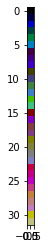

In [3]:
df = pd.read_csv("../input/camvid/CamVid/class_dict.csv")
df["r_1"] = df["r"] / 64
df["g_1"] = df["g"] / 64
df["b_1"] = df["b"] / 64
df["bin"] = df["r_1"] * 100 + df["g_1"] * 10 + df["b_1"] * 1
df = df.sort_values("bin")
df["class"] = range(len(df))
display(df.head(32))
voxel = np.zeros((len(df), 3))
voxel[:, 0], voxel[:, 1], voxel[:, 2] = df["r"], df["g"], df["b"]
voxel = np.uint8(voxel[:, np.newaxis, :])
plt.imshow(voxel)
plt.show()

In [4]:
class CamVid(Dataset):
    
    def __init__(self, image_dir, label_dir, phase = "train"):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_dir = label_dir
        self.label_fns = os.listdir(label_dir)
#         self.label_model = label_model
        self.phase = phase
        
    def __len__(self):
        return len(self.image_fns)
    
    def transform(self, image):
        transform_ops = transforms.Compose([transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        return transform_ops(image)
    
    def __getitem__(self, index):
        image_name = self.image_fns[index]
        image_path = os.path.join(self.image_dir, image_name)
        label_name = image_name[: -4] + "_L" + image_name[-4: ]
        label_path = os.path.join(self.label_dir, label_name)
        image = Image.open(image_path)
        label = np.array(transforms.Resize((256, 256), interpolation = PIL.Image.NEAREST)(Image.open(label_path)))
        label_class = np.zeros((256, 256), dtype = np.uint8)

        for idx in range(len(df)):
            mask = label == voxel[idx, :, :]
            label_class[np.all(mask, axis = 2)] = idx
#         label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = np.array(self.transform(image))
        label_class = torch.tensor(label_class).long()
        return cityscape, label_class, label

369 100 232
(3, 256, 256) torch.Size([256, 256]) (256, 256, 3)
(3, 256, 256) torch.Size([256, 256]) (256, 256, 3)
(3, 256, 256) torch.Size([256, 256]) (256, 256, 3)


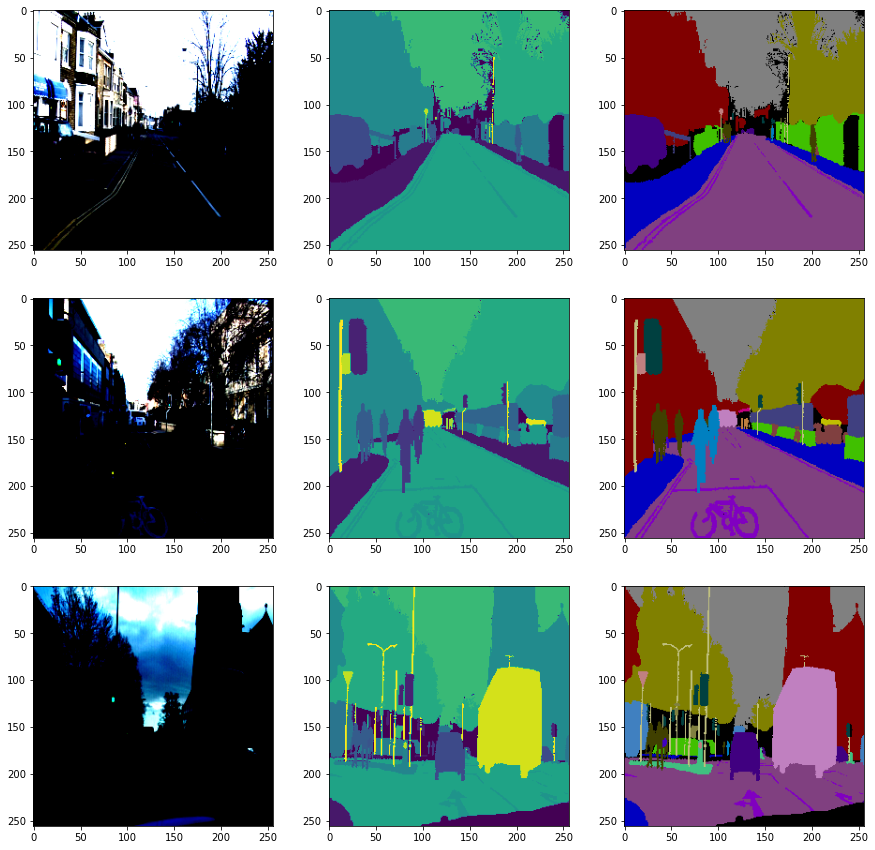

In [5]:
train_data = CamVid(train_dir, train_label_dir, phase = "train")
val_data = CamVid(val_dir, val_label_dir,  phase = "val")
test_data = CamVid(test_dir, test_label_dir, phase = "test")
print(len(train_data), len(val_data), len(test_data))

print(train_data[0][0].shape, train_data[0][1].shape, train_data[0][2].shape)
print(val_data[0][0].shape, val_data[0][1].shape, val_data[0][2].shape)
print(test_data[0][0].shape, test_data[0][1].shape, test_data[0][2].shape)

fig, axes = plt.subplots(3, 3, figsize=(15,15))
axes[0, 0].imshow(np.transpose(train_data[0][0], (1, 2, 0)))
axes[0, 1].imshow(train_data[0][1])
axes[0, 2].imshow(train_data[0][2])

axes[1, 0].imshow(np.transpose(val_data[0][0], (1, 2, 0)))
axes[1, 1].imshow(val_data[0][1])
axes[1, 2].imshow(val_data[0][2])

axes[2, 0].imshow(np.transpose(test_data[0][0], (1, 2, 0)))
axes[2, 1].imshow(test_data[0][1])
axes[2, 2].imshow(test_data[0][2])

plt.show()

In [6]:
from torchvision.models.vgg import VGG


class FCN32s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class FCN8s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class FCNs(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
        x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


In [7]:
vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCNs(pretrained_net=vgg_model, n_class=32)
fcn_model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


FCNs(
  (pretrained_net): VGGNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [8]:
n_class    = 32
batch_size = 7
epochs     = 200
lr         = 1e-2
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.9

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True)

use_gpu = torch.cuda.is_available()


if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)
print("There are {} classes to segment".format(n_class))
print("After Batching: Training Set = {}, Val Set = {}".format(len(train_loader), len(val_loader)))

def iou(pred, target):
    ious = np.zeros(n_class)
    for cls in range(n_class):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = pred_inds[target_inds].sum().float()
        union = pred_inds.sum().float() + target_inds.sum().float() - intersection
        if union == 0:
            ious[cls] = 0  
        else:
            ious[cls] = (intersection / max(union, 1)).item()  
    return ious


def pixel_acc(pred, target):
    correct = (pred == target).sum().float()
    total   = (target == target).sum().float()
    return (correct / total).item()

using device: cuda
There are 32 classes to segment
After Batching: Training Set = 53, Val Set = 15


In [9]:
# output = Variable(torch.tensor([[[[0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]],
#                                 [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0]],
#                                 [[0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]]]), requires_grad = True)
# target = torch.LongTensor([[[1, 0, 2], [1, 2, 0], [2, 0, 1]]])

# def dice_loss(output, target):
#     """
#     output : NxCxHxW Variable
#     target :  NxHxW LongTensor
#     weights : C FloatTensor
#     ignore_index : int index to ignore from loss
#     """
#     eps = 1e-5

# #     output = output.exp()
#     encoded_target = output.detach() * 0
#     encoded_target.scatter_(1, target.unsqueeze(1), 1)
#     intersection = output * encoded_target
#     numerator = 2 * intersection.sum(0).sum(1).sum(1) + eps
#     denominator = output + encoded_target

#     denominator = denominator.sum(0).sum(1).sum(1) + eps
#     loss_per_channel = (1 - (numerator / denominator))

#     return loss_per_channel.sum() / output.size(1)

# def dice_loss_smooth(score, target):
#     eps = 1e-8
    
#     numdenom = torch.zeros(score.shape[0])
#     one_hot_target = np.transpose(np.eye(score.shape[1])[target.detach().cpu().numpy().astype(int)], (0, 3, 1, 2))
#     one_hot_target = torch.cuda.LongTensor(one_hot_target)
    
#     for idx in range(score.shape[0]):
#         numerator, denominator = torch.zeros(score.shape[1]), torch.zeros(score.shape[1])
#         map1, map2 = score[idx, :, :, :], one_hot_target[idx, :, :, :]
#         numerator = 2 * torch.sum(map1 * map2, dim = (1, 2)) + eps
#         denominator = torch.sum(map1 ** 2, dim = (1, 2)) + torch.sum(map2 ** 2, dim = (1, 2)) + eps
#         numdenom[idx] = 1 - torch.mean(numerator / denominator)
        
#     loss = torch.mean(numdenom)
#     return loss

# loss = dice_loss_smooth(output, target)
# print(loss)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fcn_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
IU_scores    = np.zeros((epochs, n_class))
pixel_scores = np.zeros(epochs)
vgg_model = vgg_model.to(device)
fcn_model = fcn_model.to(device)

In [11]:
def validate():
    fcn_model.eval()
    iou_list = np.zeros((len(val_loader), n_class))
    pix_acc_list = np.zeros(len(val_loader))
    loss_list = np.zeros(len(val_loader))

    for t, (x, y, z) in enumerate(val_loader):
        optimizer.zero_grad()

        inputs = x.to(device)
        labels = y.to(device)

        scores = fcn_model.forward(inputs)

        preds = torch.argmax(scores, axis = 1).squeeze(1)
        iou_list[t, :] = iou(preds, target = labels)
        pix_acc_list[t] = pixel_acc(preds, target = labels)
        
    print("Finished Validation: {}".format(epoch + 1))
    print("mIOU = {}\nmPixAcc = {}".format(np.round(np.mean(iou_list, axis = 0), 4), 
                                               np.round(np.mean(pix_acc_list), 4)))
    

In [12]:
PATH = "/kaggle/working/fcn_model.pth"

if os.path.isfile(PATH) ==  False:
    
    loss_list_epoch = []
    for epoch in range(epochs):
        iou_list = np.zeros((len(train_loader), n_class))
        pix_acc_list = np.zeros(len(train_loader))
        loss_list = np.zeros(len(train_loader))
        fcn_model.train()
        weight, real_weight = torch.zeros(n_class), torch.zeros(n_class)
        print("\nEpoch: {}".format(epoch + 1))
        for t, (x, y, z) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs = x.to(device)
            labels = y.to(device)

            scores = fcn_model.forward(inputs)
            for idx in range(n_class):                
                real_weight[idx] = torch.sum(y==idx).item()    
            real_weight = real_weight / x.shape[0]

            real_weight[real_weight == 0] = 1e5
            weight = 1 / real_weight
            weight = weight.to(device)
            
            loss = nn.CrossEntropyLoss(weight=weight)(scores, labels) 
            
            loss.backward()
            optimizer.step()   


            preds = torch.argmax(scores, axis = 1).squeeze(1)
            iou_list[t, :] = iou(preds, target = labels)
            pix_acc_list[t] = pixel_acc(preds, target = labels)
            loss_list[t] = loss.item()

        loss_list_epoch.append(np.mean(loss_list))
        print("Loss: {}".format(np.mean(loss_list)))
        print("mIOU = {}\nmPixAcc = {}".format(np.round(np.nanmean(iou_list, axis = 0), 4), 
                                                   np.round(np.mean(pix_acc_list), 4)))
        
        validate()
  
else:
    print("Training OVER") 


Epoch: 1
Loss: 2.82994578019628
mIOU = [2.300e-03 0.000e+00 1.411e-01 3.570e-02 1.000e-04 2.560e-02 0.000e+00
 1.800e-02 2.400e-03 3.790e-02 2.770e-02 0.000e+00 3.100e-03 4.690e-02
 6.700e-03 3.000e-03 9.720e-02 1.610e-02 3.945e-01 8.000e-02 1.750e-02
 6.841e-01 0.000e+00 0.000e+00 5.900e-03 0.000e+00 0.000e+00 4.500e-03
 7.000e-03 1.210e-02 4.700e-02 3.470e-02]
mPixAcc = 0.3243
Finished Validation: 1
mIOU = [2.200e-03 0.000e+00 1.518e-01 4.650e-02 0.000e+00 2.120e-02 0.000e+00
 6.440e-02 3.300e-03 4.110e-02 1.920e-02 0.000e+00 6.200e-03 4.400e-02
 3.120e-02 1.520e-02 1.516e-01 8.400e-03 6.533e-01 1.193e-01 2.040e-02
 7.513e-01 2.000e-04 0.000e+00 4.070e-02 0.000e+00 0.000e+00 5.900e-03
 1.060e-02 1.810e-02 8.010e-02 4.660e-02]
mPixAcc = 0.42

Epoch: 2
Loss: 2.2955405532189137
mIOU = [4.500e-03 9.000e-04 2.268e-01 7.930e-02 0.000e+00 6.160e-02 0.000e+00
 1.066e-01 5.600e-03 5.870e-02 4.750e-02 2.000e-04 9.300e-03 9.290e-02
 1.650e-02 4.080e-02 2.147e-01 2.520e-02 5.989e-01 1.926e-01 3

In [13]:
torch.save(fcn_model, PATH)
fcn_model = torch.load(PATH)

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type FCNs. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type VGGNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


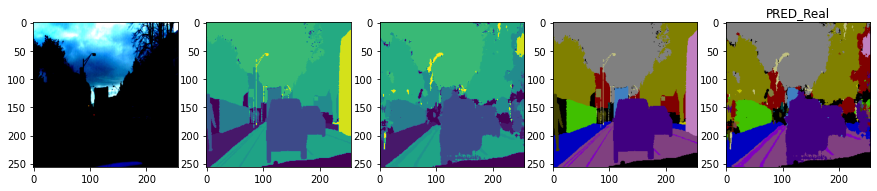

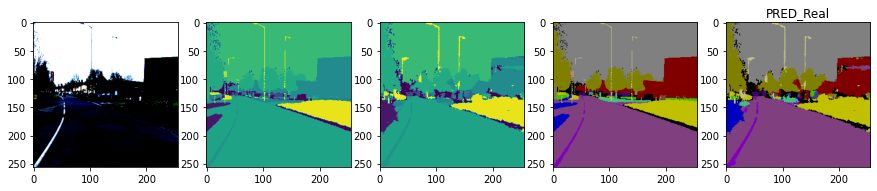

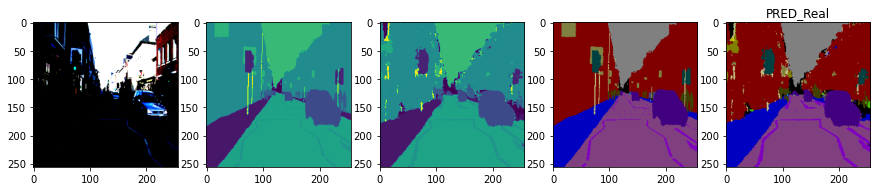

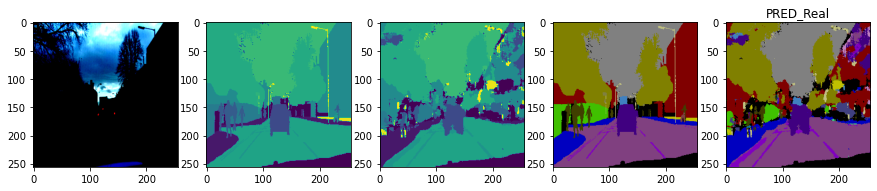

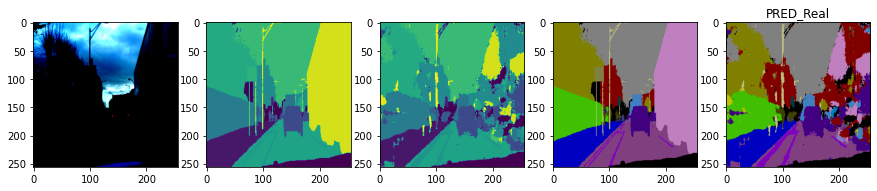

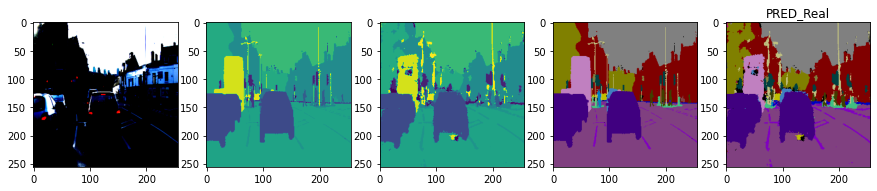

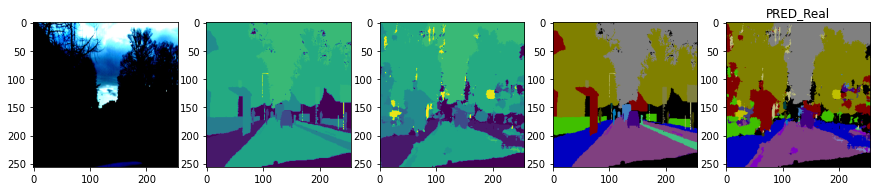

Finished Validation: 200
mIOU = [0.28 0.   0.61 0.23 0.   0.13 0.   0.52 0.02 0.23 0.15 0.01 0.11 0.27
 0.08 0.63 0.39 0.13 0.84 0.53 0.16 0.9  0.03 0.   0.03 0.   0.   0.06
 0.12 0.08 0.13 0.16]
mPixAcc = 0.81


In [14]:
test_loader = DataLoader(test_data, batch_size = 1)

def test():
    fcn_model.eval()
    iou_list = np.zeros((len(test_loader), n_class))
    pix_acc_list = np.zeros(len(test_loader))
    loss_list = np.zeros(len(test_loader))

    for t, (x, y, z) in enumerate(test_loader):
        optimizer.zero_grad()

        inputs = x.to(device)
        labels = y.to(device)

        scores = fcn_model.forward(inputs)

        preds = torch.argmax(scores, axis = 1).squeeze(1)
        iou_list[t, :] = iou(preds, target = labels)
        pix_acc_list[t] = pixel_acc(preds, target = labels)
        
        if (t + 1) % 30 == 0:
            img_array = np.transpose(x.squeeze(0), (1, 2, 0))
            label_array = y.squeeze(0)
            predicted = preds.squeeze(0).detach().cpu().numpy()
            real_label = z.squeeze(0).detach().cpu().numpy() 
            recon_image = np.zeros((256, 256, 3), dtype = np.uint8)
            for idx in range(len(df)):
                mask = (predicted == idx)
                recon_image[mask, 0] = int(df[df["class"] == idx]["r"].values)
                recon_image[mask, 1] = int(df[df["class"] == idx]["g"].values)
                recon_image[mask, 2] = int(df[df["class"] == idx]["b"].values)
            
            fig, axes = plt.subplots(1, 5, figsize=(15,15))
            plt.title("Image")
            axes[0].imshow(img_array)
            plt.title("GT_Clustered")
            axes[1].imshow(label_array)
            plt.title("PRED_Clustered")
            axes[2].imshow(predicted)
            plt.title("GT_Real")
            axes[3].imshow(real_label)
            plt.title("PRED_Real")  
            axes[4].imshow(recon_image)

            plt.show()
        
    print("Finished Validation: {}".format(epoch + 1))
    print("mIOU = {}\nmPixAcc = {}".format(np.round(np.mean(iou_list, axis = 0), 2), 
                                               np.round(np.mean(pix_acc_list), 2)))
    
test()